# Cluster and Visualize Unlabeled Acoustic Embeddings (PCA)

This notebook:
1. Creates interactive PCA plots for review (using first 3 components from 256D PCA)

### Setup

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from os import environ

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

import librosa
import librosa.display
from IPython.display import Audio, display

In [8]:
# Cell 2 — robust data path setup + load embeddings/manifest
env_dir = environ.get("POSIDONIA_DATASET_DIR")
DATASET_DIR = Path(env_dir) if env_dir else Path("D:/Posidonia Soundscapes/Fondeo 1_Formentera Ille Espardell/Embeddings_2/dataset")

EMBEDDINGS_PATH = DATASET_DIR / "npy_files" / "unlabeled_embeddings.npy"
MANIFEST_PATH = DATASET_DIR / "unlabeled_manifest.csv"

if not EMBEDDINGS_PATH.exists() or not MANIFEST_PATH.exists():
    raise FileNotFoundError(
        f"Missing files:\n"
        f"  embeddings: {EMBEDDINGS_PATH}\n"
        f"  manifest:   {MANIFEST_PATH}\n"
        f"Set POSIDONIA_DATASET_DIR to the correct dataset folder."
    )

embeddings = np.load(str(EMBEDDINGS_PATH))
manifest_df = pd.read_csv(str(MANIFEST_PATH))

print(f"Loaded {embeddings.shape[0]} embeddings of dimension {embeddings.shape[1]}")
print(f"Manifest rows: {len(manifest_df)}")
manifest_df.head()

Loaded 392400 embeddings of dimension 1536
Manifest rows: 392400


,original_audio,embedding_path,segment_path,audio_path,file_name,embedding_dim
0,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,NaN,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,channelA_2025-05-16_14-00-03.wav,1536
1,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,NaN,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,channelA_2025-05-16_14-00-08.wav,1536
2,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,NaN,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,channelA_2025-05-16_14-00-13.wav,1536
3,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,NaN,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,channelA_2025-05-16_14-00-18.wav,1536
4,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,NaN,/mnt/d/Posidonia Soundscapes/Fondeo 1_Formente...,channelA_2025-05-16_14-00-23.wav,1536


In [9]:
# Cell 3 — load or compute PCA (for visualization)
output_dir = EMBEDDINGS_PATH.parent
pca_output_dir = output_dir / "PCA_256D"
pca_file = pca_output_dir / "pca_embeddings_256d.npy"

if pca_file.exists():
    print("Loading pre-computed PCA embeddings...")
    pca_results = np.load(str(pca_file))
    print(f"Loaded PCA: {pca_results.shape}")
else:
    print("Computing PCA(256D)...")
    embeddings_fp32 = embeddings.astype(np.float32, copy=False)
    pca_model = PCA(n_components=256, random_state=42)
    pca_results = pca_model.fit_transform(embeddings_fp32)

    np.save(str(pca_file), pca_results)
    print(f"Saved PCA embeddings to: {pca_file}")

print("PCA shape:", pca_results.shape)

Loading pre-computed PCA embeddings...
Loaded PCA: (392400, 256)
PCA shape: (392400, 256)


In [10]:
# Cell 4 — load or compute PCA cluster labels (for coloring in plots)
k = 25

pca_labels_file = pca_output_dir / f"pca_kmeans_labels_k{k}.npy"

if pca_labels_file.exists():
    print(f"Loading pre-computed PCA K-means labels (k={k})...")
    pca_labels = np.load(str(pca_labels_file))
else:
    print(f"Computing K-means clustering (k={k}) on PCA embeddings...")
    pca_labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(pca_results)
    np.save(str(pca_labels_file), pca_labels)

print("PCA labels:", pca_labels.shape)
print(f"Cluster distribution:")
print(pd.Series(pca_labels).value_counts().sort_index())

Loading pre-computed PCA K-means labels (k=25)...
PCA labels: (392400,)
Cluster distribution:
0     20199
1     10360
2     27126
3      9163
4     44162
5     16135
6      3860
7      7366
8     11850
9     12733
10    22614
11    10742
12    33893
13    12962
14    31618
15    17412
16    13520
17     8825
18    19238
19     7808
20     5844
21    15139
22     7389
23    15138
24     7304
Name: count, dtype: int64


### Visualize

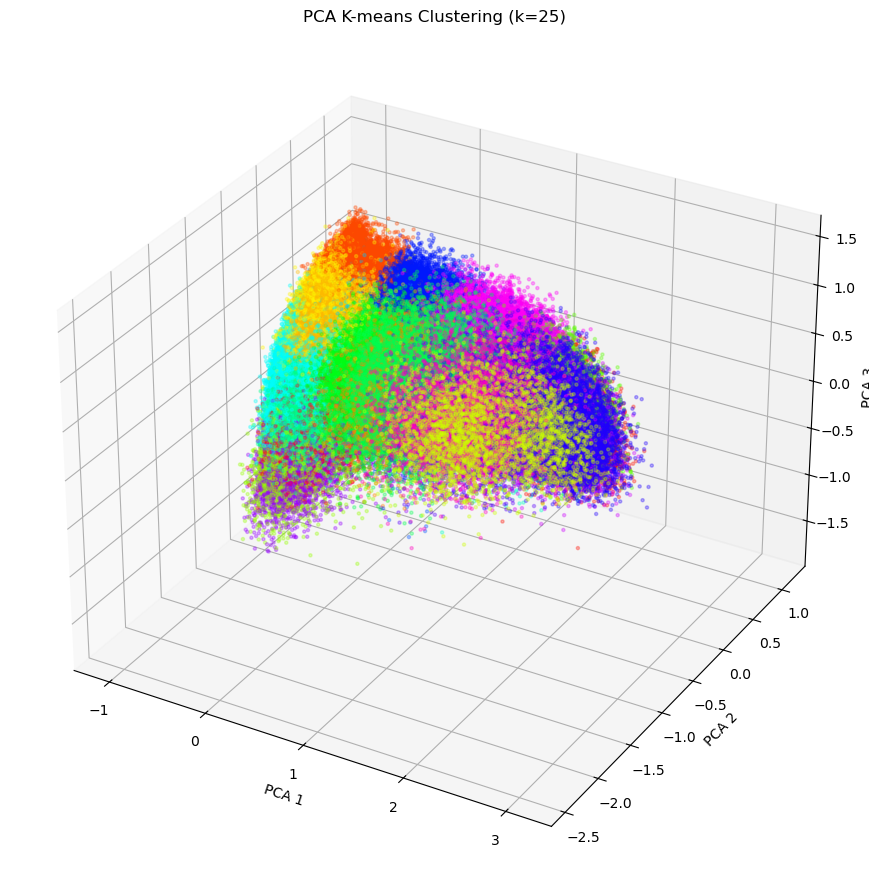

In [11]:
# Cell 5 — static 3D PCA visualization (matplotlib)
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    pca_results[:, 0], pca_results[:, 1], pca_results[:, 2],
    c=pca_labels, cmap="gist_rainbow", s=5, alpha=0.3
)
ax.set_title(f"PCA K-means Clustering (k={k})")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.tight_layout()
plt.show()

In [ ]:
# Cell 6 — interactive PCA 3D (Plotly)
plot_df = pd.DataFrame({
    "x": pca_results[:, 0],
    "y": pca_results[:, 1],
    "z": pca_results[:, 2],
    "cluster": pca_labels.astype(str),
    "audio_file": manifest_df["audio_path"].apply(lambda x: Path(x).name) if "audio_path" in manifest_df.columns else "n/a"
})

fig = px.scatter_3d(
    plot_df,
    x="x", y="y", z="z",
    color="cluster",
    hover_data=["cluster", "audio_file"],
    title=f"PCA (first 3 of 256 components) with K-Means Clusters (k={k})",
    labels={"x": "PCA 1", "y": "PCA 2", "z": "PCA 3"},
    opacity=0.7
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(height=800)
fig.show()